In [24]:
from typing import List
from copy import deepcopy

import random
import collections

import h5py

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.passes import RemoveFinalMeasurements
from qiskit.qasm2 import dumps

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates, project_operator_to_subspace

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [2]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/backends/nighthawk/fake_nighthawk.py:76: UserWarning: Properties of fake_nighthawk are not intended to represent typical nighthawk error values.
  warnings.warn(


## Build a tiled pool

In [3]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 31]...
Starting point: [np.float64(-0.5535743588970441), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132743
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 31, 228]...
Starting point: [np.float64(-0.7853981718257756), np.float64(-0.7853981815917112), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.1231056256176366)
Current ansatz: [241, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441852
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710474289297)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 31, 228, 210]...
Starting point: [np.float64(-0.7853981609748782), np.float64(-0.785398165605737), np.float64(0.12248927934333585), np.float64(0.0)]

Current energy: -6.327276154819979
(change of -0.20417052920233214)
Current ansatz: [241, 31, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964031959605
Operator(s) added to ansatz: [108]
Gradients: [np.float64(2.0894916521413123)]
Initial energy: -6.327276154819979
Optimizing energy with indices [241, 31, 228, 210, 108]...
Starting point: [np.float64(-0.7853981630747

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625562494
(change of -0.12310562563297633)
Current ansatz: [228, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620177583
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071048468285)]
Initial energy: -6.123105625562494
Optimizing energy with indices [228, 79, 225, 210]...
Starting point: [np.float64(-0.7853947065772614), np.float64(0.7853985308794381), np.float64(-0.12248927961669928), np.float64(0.0)]

Current energy: -6.327276154764743
(change of -0.20417052920224865)
Current ansatz: [228, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962581220501
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894929267302738)]
Initial energy: -6.327276154764743
Optimizing energy with indices [228, 79, 225, 210, 198]...
Starting point: [np.float64(-0.7853947065771

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113274
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000013)]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 26, 225]...
Starting point: [np.float64(-0.7853981718257758), np.float64(0.7853981815917098), np.float64(0.0)]

Current energy: -6.12310562561764
(change of -0.1231056256176295)
Current ansatz: [241, 26, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442571
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710474293334)]
Initial energy: -6.12310562561764
Optimizing energy with indices [241, 26, 225, 210]...
Starting point: [np.float64(-0.7853981643039402), np.float64(0.785398162943446), np.float64(-0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442424
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710474292477)]
Initial energy: -6.1231056256176455
Optimizing energy with indices [244, 79, 177, 210]...
Starting point: [np.float64(0.7853981579808232), np.float64(0.785398168336467), np.float64(0.12248927934341783), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548200815
(change of -0.20417052920243606)
Current ansatz: [244, 79, 177, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409636629214
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.089491976216662)]
Initial energy: -6.3272761548200815
Optimizing energy with indices [244, 79, 177, 210, 147]...
Starting point: [np.float64(0.7853981500604383), np.float64(0.7853981641132793), np.float64(0.16357026340856168), np.float64(0.16356988508833512), np.float64(0.0)]

Current energy: -6.464101615071806
(change of -0.1368254602517247)
Current ansatz: [244, 79, 177, 210, 147]
Performing final convergence check...
Total gradient norm: 0.0001356813121464756

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.2409636629214 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047767142)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 198]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.327276154819957
(change of -0.20417052920230994)
Current ansatz: [244, 74, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640413812895
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.089491643867187)]
Initial energy: -6.327276154819957
Optimizing energy with indices [244, 74, 225, 198, 120]...
Starting point: [np.float64(0.7853981633827103), np.float64(-0.7853981633905597), np.float64(-0.1635702864850013), np.float64(-0.16356997194328274), np.float64(0.0)]

Current energy: -6.464101615072789
(change of -0.13682546025283138)
Current 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620177583
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071048468284)]
Initial energy: -6.123105625562494
Optimizing energy with indices [228, 79, 225, 198]...
Starting point: [np.float64(-0.7853947065772614), np.float64(0.7853985308794381), np.float64(-0.12248927961669928), np.float64(0.0)]

Current energy: -6.327276154764998
(change of -0.20417052920250356)
Current ansatz: [228, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042069151
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089491643863277)]
Initial energy: -6.327276154764998
Optimizing energy with indices [228, 79, 225, 198, 210]...
Starting point: [np.float64(-0.785394706577125), np.float64(0.7853982468601275), np.float64(-0.16357028648717148), np.float64(-0.16356997194354164), np.float64(0.0)]

Current energy: -6.4641016150180395
(change of -0.13682546025304188)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200768382
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710481682663)]
Initial energy: -6.1231056256176455
Optimizing energy with indices [244, 79, 216, 201]...
Starting point: [np.float64(0.7853981633974504), np.float64(0.7853981633974519), np.float64(-0.1224892795338588), np.float64(0.0)]

Current energy: -6.327276154819708
(change of -0.20417052920206213)
Current ansatz: [244, 79, 216, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531913
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0894929267348763)]
Initial energy: -6.327276154819708
Optimizing energy with indices [244, 79, 216, 201, 225]...
Starting point: [np.float64(0.7853981633974537), np.float64(0.7853981633975231), np.float64(-0.16357019740839485), np.float64(0.16356963668288216), np.float64(0.0)]

Current energy: -6.464101615135399
(change of -0.13682546031569132)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 198]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819706
(change of -0.20417052920206658)
Current ansatz: [244, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 198]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.1224892

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917497202613596
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.4850548713171983)]
Initial energy: -6.123105622932899
Optimizing energy with indices [211, 225, 79, 225, 57]...
Starting point: [np.float64(1.8096680366912038e-05), np.float64(0.7854142667466679), np.float64(0.7854289439686392), np.float64(-0.12248511340154183), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154767315
(change of -0.20417053183441602)
Current ansatz: [211, 225, 79, 225, 57]
Performing final convergence check...
Total gradient norm: 6.240962176675174

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 8.917497202613596 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.0000000000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 210]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.20417052920234013)
Current ansatz: [241, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.24096404138082
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916438682527)]
Initial energy: -6.327276154819982
Optimizing energy with indices [241, 79, 228, 210, 147]...
Starting point: [np.float64(-0.7853982024976439), np.float64(0.7853981311150512), np.float64(0.1635702864850446), np.float64(0.16356997194303877), np.float64(0.0)]

Current energy: -6.464101614554787
(change of -0.13682545973480487)
Current ansatz: [241, 79, 228, 210, 147]
Performing final convergence check...
Total gradient norm: 0.00033002084338061577

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.24096404138082 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 228]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.123105625617642
(change of -0.1231056256176366)
Current ansatz: [241, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474288453)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 147]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), n

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 2.7904919049184394e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.2409625805317495 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.flo

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 120]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819982
(change of -0.2041705292023428)
Current ansatz: [244, 79, 228, 120]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964043040389
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.0894916424102608)]
Initial energy: -6.327276154819982
Optimizing energy with indices [244, 79, 228, 120, 147]...
Starting point: [np.float64(0.7853981556136755), np.float64(0.7853981624051032), np.float64(0.16357028658616155), np.float64(0.16356997232403198), np.float64(0.0)]

Current energy: -6.464101615070806
(change of -0.1368254602508241)
Current ansatz: [244, 79, 228, 120, 147]
Performing final convergence check...
Total gradient norm: 0.00013640859207318388

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964043040389 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561764282)
Current ansatz: [241, 74, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201327167
Operator(s) added to ansatz: [99]
Gradients: [np.float64(-2.485071048479704)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 74, 210, 99]...
Starting point: [np.float64(-0.7853981648267379), np.float64(-0.7853981619178165), np.float64(0.12248927961411439), np.float64(0.0)]

Current energy: -6.327276154819971
(change of -0.20417052920232415)
Current ansatz: [241, 74, 210, 99]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042447104
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.089491642931434)]
Initial energy: -6.327276154819971
Optimizing energy with indices [241, 74, 210, 99, 225]...
Starting point: [np.float64(-0.7853981607940907)

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.79795897113273
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000004)]
Initial energy: -6.000000000000005
Optimizing energy with indices [244, 74, 228]...
Starting point: [np.float64(0.7853981703433218), np.float64(-0.7853981783720295), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [244, 74, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 210]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.3272761548199865
(change of -0.20417052920233925)
Current ansatz: [244, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240964042725676
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916426871495)]
Initial energy: -6.3272761548199865
Optimizing energy with indices [244, 74, 228, 210, 198]...
Starting point: [np.float64(0.7853981633887943), np.float64(-0.7853981634091799), np.float64(0.1635702865670706), np.float64(0.16356997225170858), np.float64(0.0)]

Current energy: -6.464101615072771
(change of -0.1368254602527843)
Current ansatz: [244, 74, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013503875513833517

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964042725676 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [225]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998192
(change of -1.763932022498393)
Current ansatz: [225, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140577
Operator(s) added to ansatz: [216]
Gradients: [np.float64(1.9999999999993738)]
Initial energy: -5.999999999998192
Optimizing energy with indices [225, 26, 216]...
Starting point: [np.float64(0.7853985607314246), np.float64(0.7853989420959444), np.float64(0.0)]

Current energy: -6.123105625475228
(change of -0.12310562547703618)
Current ansatz: [225, 26, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526155313158
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710224817094)]
Initial energy: -6.123105625475228
Optimizing energy with indices [225, 26, 216, 201]...
Starting point: [np.float64(0.7854038548068972), np.float64(0.7854037257861561), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761547130445
(change of -0.20417052923781664)
Current ansatz: [225, 26, 216, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240978887950446
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.08949121105992)]
Initial energy: -6.3272761547130445
Optimizing energy with indices [225, 26, 216, 201, 225]...
Starting point: [np.float64(0.7853989937437026), np.float64(0.785398627754708), np.float64(-0.1635735761816369), np.float64(0.16357099415055973), np.float64(0.0)]

Current energy: -6.464101614687843
(change of -0.13682545997479867)
Current ansatz: [225, 26, 216, 201, 225]
Performing final convergence check...
Total gradient norm: 0.00032427949597655016

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240978887950446 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819989
(change of -0.2041705292023437)
Current ansatz: [244, 31, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964057111225
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.0894916300540904)]
Initial energy: -6.327276154819989
Optimizing energy with indices [244, 31, 225, 147, 45]...
Starting point: [np.float64(0.7853981617410489), np.float64(-0.7853981704951554), np.float64(-0.16357028744417224), np.float64(-0.16356997555316646), np.float64(0.0)]

Current energy: -6.464101615062081
(change of -0.13682546024209152)
Current ansatz: [244, 31, 225, 147, 45]
Performing final convergence check...
Total gradient norm: 0.00014154747507459978

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057111225 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating li

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [216]
Gradients: [np.float64(1.999999999952205)]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 216]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.1231056252069065
(change of -0.12310562527738877)
Current ansatz: [228, 79, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917518430081312
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485066714324805)]
Initial energy: -6.1231056252069065
Optimizing energy with indices [228, 79, 216, 225]...
Starting point: [np.float64(-0.7853879048615375), np.float64(0.7853901599313474), np.float64(-0.12

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132743
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 31, 228]...
Starting point: [np.float64(-0.7853981718257756), np.float64(-0.7853981815917112), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.1231056256176366)
Current ansatz: [241, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441852
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485071047428929)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 31, 228, 147]...
Starting point: [np.float64(-0.7853981609748782), np.float64(-0.785398165605737), np.float64(0.12248927934333585), np.float64(0.0)]

Current energy: -6.327276154819714
(change of -0.20417052920206658)
Current ansatz: [241, 31, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531371
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.0894929267356046)]
Initial energy: -6.327276154819714
Optimizing energy with indices [241, 31, 228, 147, 120]...
Starting point: [np.float64(-0.78539816637922

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929516
(change of -1.7639320224297173)
Current ansatz: [225, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647983
Operator(s) added to ansatz: [216]
Gradients: [np.float64(1.9999999999522045)]
Initial energy: -5.999999999929516
Optimizing energy with indices [225, 31, 216]...
Starting point: [np.float64(0.7853947065773541), np.float64(-0.7853993777262479), np.float64(0.0)]

Current energy: -6.12310562554803
(change of -0.12310562561851413)
Current ansatz: [225, 31, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917506431652077
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.4850600293815126)]
Initial energy: -6.12310562554803
Optimizing energy with indices [225, 31, 216, 225]...
Starting point: [np.float64(0.785397752176819), np.float64(-0.7853977934283553), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013756987441307736

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962578717634 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 74]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526200048677
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.485071047767142)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 225, 198]...
Starting point: [np.float64(0.7853981633976963), np.float64(-0.7853981633977503), np.float64(-0.12248927943049101), np.float64(0.0)]

Current energy: -6.327276154819957
(change of -0.20417052920230994)
Current ansatz: [244, 74, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640413812895
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.0894916438671864)]
Initial energy: -6.327276154819957
Optimizing energy with indices [244, 74, 225, 198, 135]...
Starting point: [np.float64(0.7853981633827103), np.float64(-0.7853981633905597), np.float64(-0.1635702864850013), np.float64(-0.16356997194328274), np.float64(0.0)]

Current energy: -6.4641016150727975
(change of -0.13682546025284026)
Curren

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526155291553
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.4850710218478644)]
Initial energy: -6.123105625475222
Optimizing energy with indices [225, 26, 201, 228]...
Starting point: [np.float64(0.7854038547268218), np.float64(0.7854037258684557), np.float64(0.12248927291321572), np.float64(0.0)]

Current energy: -6.327276154553893
(change of -0.20417052907867106)
Current ansatz: [225, 26, 201, 228]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240988009234623
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.0894918978883172)]
Initial energy: -6.327276154553893
Optimizing energy with indices [225, 26, 201, 228, 216]...
Starting point: [np.float64(0.7853981597106641), np.float64(0.7853980963483322), np.float64(0.16357577710850302), np.float64(0.1635714417780574), np.float64(0.0)]

Current energy: -6.464101615054367
(change of -0.13682546050047417)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00014732310267472507

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240988009234623 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 74]...
Starting point: [np.float64(-0.5535743588970441), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101615072614
(change of -0.1368254602526422)
Current ansatz: [241, 74, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013515787565729383

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057733311 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [199]
Gradients: [np.float64(-4.000000000000012)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [199]...
Starting point: [np.float64(0.0)]

Current energy: -3.828427124746197
(change of -0.8284271247461925)
Current ansatz: [199]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.78207252017211
Operator(s) added to ansatz: [241]
Gradients: [np.float64(3.4142135

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625614734
(change of -1.4968210859797662)
Current ansatz: [199, 241, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91753072080658
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.4850735673672766)]
Initial energy: -6.123105625614734
Optimizing energy with indices [199, 241, 79, 216]...
Starting point: [np.float64(0.12248992871667236), np.float64(-0.7853981486095067), np.float64(0.7853981593384867), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819715
(change of -0.2041705292049807)
Current ansatz: [199, 241, 79, 216]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580953858
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0894929267340707)]
Initial energy: -6.327276154819715
Optimizing energy with indices [199, 241, 79, 216, 228]...
Starting point: [np.float64(0.16357019750407203), np.float64(-0.7853981538777904), np.float64(0.7853981498044458), np.float64(-0.16356963670976166), np.float64(0.0)]

Current energy: -6.464101615133892
(change of -0.13682546031417697)
Current ansatz: [199, 241, 79, 216, 228]
Performing final convergence check...
Total gradient norm: 2.950522516897004e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580953858 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating l

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201327167
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485071048479704)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 74, 210, 225]...
Starting point: [np.float64(-0.7853981648267379), np.float64(-0.7853981619178165), np.float64(0.12248927961411439), np.float64(0.0)]

Current energy: -6.327276154819705
(change of -0.2041705292020577)
Current ansatz: [241, 74, 210, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409625805319635
Operator(s) added to ansatz: [156]
Gradients: [np.float64(-2.089492926734877)]
Initial energy: -6.327276154819705
Optimizing energy with indices [241, 74, 210, 225, 156]...
Starting point: [np.float64(-0.7853981627312019), np.float64(-0.7853981642548087), np.float64(0.1635701974084066), np.float64(-0.16356963668288516), np.float64(0.0)]

Current energy: -6.4641016151329485
(change of -0.1368254603132435)
Current a

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [26]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 26]...
Starting point: [np.float64(0.5535743588970456), np.floa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199440323
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485071047428078)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 26, 228, 147]...
Starting point: [np.float64(0.7853981611549227), np.float64(0.7853981650265573), np.float64(0.1224892793431165), np.float64(0.0)]

Current energy: -6.327276154819722
(change of -0.20417052920207457)
Current ansatz: [244, 26, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531802
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.08949292673492)]
Initial energy: -6.327276154819722
Optimizing energy with indices [244, 26, 228, 147, 210]...
Starting point: [np.float64(0.7853981509462105), np.float64(0.7853981697196195), np.float64(0.16357019740836923), np.float64(-0.16356963668286592), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.464101614820616
(change of -0.13682546000089424)
Current ansatz: [244, 26, 228, 147, 210]
Performing final convergence check...
Total gradient norm: 0.00028018709846451973

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531802 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.00000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0000000000000018)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 225]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474305875)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 198]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 6.240963610610418
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.0894920221535047)]
Initial energy: -6.32727615482008
Optimizing energy with indices [244, 79, 225, 198, 45]...
Starting point: [np.float64(0.7853981493735948), np.float64(0.7853981777037257), np.float64(-0.16357026021874255), np.float64(-0.16356987308330864), np.float64(0.0)]

Current energy: -6.464101615060376
(change of -0.13682546024029651)
Current ansatz: [244, 79, 225, 198, 45]
Performing final convergence check...
Total gradient norm: 0.0001431476457954306

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963610610418 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [199]
Gradients: [np.float64(-4.000000000000012)]
Initial energy: -3.000000000000

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999417225
(change of -1.3737154597822574)
Current ansatz: [199, 244, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958970181076
Operator(s) added to ansatz: [225]
Gradients: [np.float64(1.9999999998057456)]
Initial energy: -5.999999999417225
Optimizing energy with indices [199, 244, 79, 225]...
Starting point: [np.float64(9.855378907157579e-06), np.float64(0.7853981714335022), np.float64(0.7853981407341485), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625047579
(change of -0.12310562563035354)
Current ansatz: [199, 244, 79, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620051138
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.48507104825217)]
Initial energy: -6.123105625047579
Optimizing energy with indices [199, 244, 79, 225, 147]...
Starting point: [np.float64(9.64191961696969e-06), np.float64(0.7853983074094039), np.float64(0.7853977639812335), np.float64(-0.12248927961513552), np.float64(0.0)]

Current energy: -6.327276154616105
(change of -0.20417052956852633)
Current ansatz: [199, 244, 79, 225, 147]
Performing final convergence check...
Total gradient norm: 6.240984773527567

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 8.91752620051138 > 1e-05)
Pool will be tiled from 24 ops


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


## Run ADAPT at larger size to get a sequence of circuits.

In [4]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [5]:
# Now go to the larger size.
new_l = 2 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(10):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    circuit = data.get_circuit(
        tiled_pool, indices=tn_adapt.indices, coefficients=tn_adapt.coefficients,
        include_ref=True
    )
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 8
Got DMRG energy -1.34997e+01
Tiled pool has 92 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -6.999999999999975
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.99999999999997
Operator 1: -3.999999999999984
Operator 2: 3.9999999999999902
Operator 3: -3.999999999999996
Operator 4: 3.9999999999999947
Operator 5: 3.9999999999999862
Operator 6: -3.999999999999985
Operator 7: 3

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 5: 3.2645854300808157
Operator 7: 2.7995881298939964
Operator 8: -0.9299946930004366
Operator 9: 3.2645853903961335
Operator 10: 2.5291707807922785
Operator 11: 3.9999999999999987
Operator 12: 0.9299946093880005
Operator 13: -2.7995881298939964
Operator 14: 1.719961910673362e-07
Operator 15: -3.264585390396134
Operator 16: -3.9999999999999996
Operator 18: 1.2004118701059776
Operator 22: -3.2645854300808166
Operator 24: -2.529170820476948
Operator 25: -1.719961910673362e-07
Operator 26: -3.264585390396134
Operator 27: -2.7995881298939964
Operator 28: 0.9299946930004366
Operator 29: -3.264585390396134
Operator 30: -2.5291707807922785
Operator 31: -3.9999999999999987
Operator 32: -0.9299946093880005
Operator 33: 2.7995881298939964
Operator 34: -1.719961910673362e-07
Operator 35: 3.2645853903961335
Operator 36: 3.9999999999999996
Operator 37: -2.0641735202901486
Operator 39: -2.7995881298939964
Operator 40: -1.719961910673362e-07
Operator 41: -3.2645853903961335
Operator 42: 3.999

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -11.646025
         Iterations: 12
         Function evaluations: 46
         Gradient evaluations: 35

Current energy: -11.646025075928302
(change of -0.46451525279941563)
Current ansatz: [53, 49, 42, 43, 22, 29]
On iteration 6.

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.251256462222888
Operator 1: 6.871857862717844e-08
Operator 2: 1.1386704806491201
Operator 3: -0.6349747980422835
Operator 4: 0.6989700072913343
Operator 5: 1.073827830232237
Operator 7: 2.130996212751798
Operator 8: 0.6182933044380854
Operator 9: 1.4928165997638998
Operator 10: 1.4072108217251487
Operator 11: 0.020489082675519944
Operator 12: -0.927013477552269
Operator 13: -2.680339053042045
Operator 14: 0.33852865298596385
Operator 15: 1.229551943981285
Operator 16: 2.7543354787370154e-08
Operator 17: -0.6512085040253338
Operator 18: 0.3477050626990194
Operator 20: 0.2128587692

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -12.580646
         Iterations: 16
         Function evaluations: 84
         Gradient evaluations: 71

Current energy: -12.580646354206175
(change of -0.1993854060246285)
Current ansatz: [53, 49, 42, 43, 22, 29, 0, 69]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -6.843633282294093e-08
Operator 1: -0.6022770389498576
Operator 2: 0.16108032793595845
Operator 3: -0.2814667022664954
Operator 4: -0.1022961976963905
Operator 5: 0.15659428731080638
Operator 6: -0.4417041243539007
Operator 7: -2.230913626954307
Operator 8: 1.9151723498467632
Operator 9: -1.548418556937632
Operator 10: -0.6671209955063098
Operator 11: -1.939602946794877
Operator 12: -1.8963158290607582
Operator 13: 2.1842934020797493
Operator 14: 0.169057797395073
Operator 15: 1.982304814382729
Operator 16: 0.6612982499439666
Operator 17: -0.169340076537096
Operator 18: -0.00

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -12.775842
         Iterations: 18
         Function evaluations: 98
         Gradient evaluations: 83

Current energy: -12.77584245423472
(change of -0.1951961000285447)
Current ansatz: [53, 49, 42, 43, 22, 29, 0, 69, 61]
On iteration 9.

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 2: 3.513476820104554e-08
Operator 3: -3.553102170103608e-08
Operator 4: -1.493164898513839e-08
Operator 6: -5.1302148654230884e-08
Operator 7: -2.273916255029153
Operator 8: -0.7126130386279874
Operator 9: -1.9240285696183301
Operator 10: -0.8614372950996239
Operator 11: -2.0746093105753887
Operator 12: -1.7457480305545818
Operator 13: 2.0171173228600234
Operator 14: 0.812430768325273
Operator 15: 1.9442435756470513
Operator 16: 0.7438878898963528
Operator 17: 0.2212081116572763
Operator 18: -0.5839654164989875
Operator 19: -0.7388831109180293
Operator 20: -0.152150971437052

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [6]:
for circuit in circuits:
    print(circuit.depth())

9
16
21
26
31
38
43
50
57
64


Text(0, 0.5, 'Energy error')

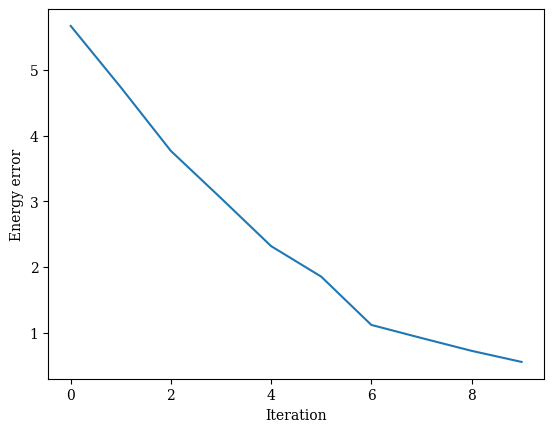

In [7]:
adapt_errors = abs(np.array(adapt_energies) - exact_energy)
fig, ax = plt.subplots()
ax.plot(adapt_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [8]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [9]:
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    isa_circuit = RemoveFinalMeasurements()(isa_circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [10]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

Text(0, 0.5, 'Energy error')

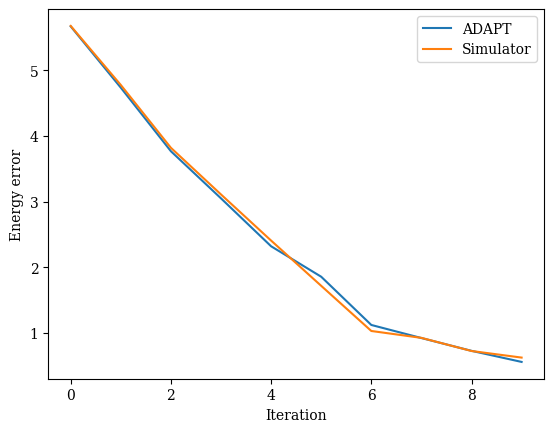

In [11]:
fig, ax = plt.subplots()
ax.plot(adapt_errors, label="ADAPT")
ax.plot(simualtor_errors, label="Simulator")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [15]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [45]:
shots_per_circuit = 10_000
num_shots = len(circuits) * shots_per_circuit
sampler = Sampler(sim)

In [46]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sim.run(to_run)
    # counts = job.result().data()['counts']
    # bit_array = BitArray.from_counts(counts, num_bits=circuit.num_qubits)
    # counts1 = bit_array.get_counts()
    # num_shots = (i+1) * shots_per_circuit
    job = sampler.run((circuit,), shots=num_shots)
    data = job.result()[0].data
    bit_array = data['meas']
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/10
Gate counts (w/ pre-init passes): OrderedDict({'measure': 8, 'cx': 6, 'x': 3, 'h': 2, 'rx': 2, 'barrier': 2, 'rz': 1})
On circuit 1/10
Gate counts (w/ pre-init passes): OrderedDict({'cx': 10, 'measure': 8, 'h': 4, 'rx': 4, 'x': 3, 'barrier': 3, 'rz': 2})
On circuit 2/10
Gate counts (w/ pre-init passes): OrderedDict({'cx': 12, 'measure': 8, 'h': 6, 'rx': 6, 'barrier': 4, 'x': 3, 'rz': 3})
On circuit 3/10
Gate counts (w/ pre-init passes): OrderedDict({'cx': 14, 'h': 8, 'rx': 8, 'measure': 8, 'barrier': 5, 'rz': 4, 'x': 3})
On circuit 4/10
Gate counts (w/ pre-init passes): OrderedDict({'cx': 16, 'h': 10, 'rx': 10, 'measure': 8, 'barrier': 6, 'rz': 5, 'x': 3})
On circuit 5/10
Gate counts (w/ pre-init passes): OrderedDict({'cx': 20, 'h': 12, 'rx': 12, 'measure': 8, 'barrier': 7, 'rz': 6, 'x': 3})
On circuit 6/10
Gate counts (w/ pre-init passes): OrderedDict({'cx': 22, 'h': 14, 'rx': 14, 'barrier': 8, 'measure': 8, 'rz': 7, 'x': 3})
On circuit 7/10
Gate counts (w/ pre-init pa

In [47]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

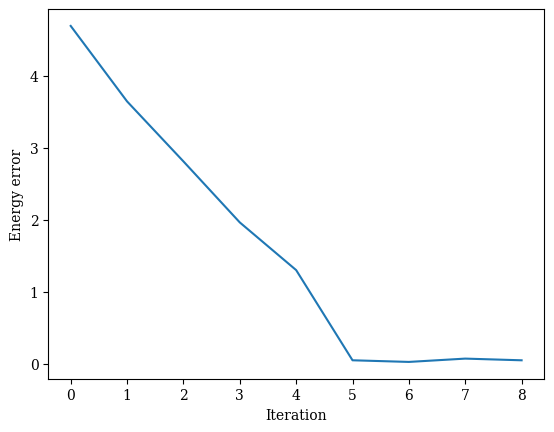

In [48]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [58]:
def randomly_combine_bit_arrays(bit_arrays: List[BitArray], total_shots: int) -> BitArray:
    """Combine several bit arrays by choosing the same number of shots from each of them.
    Choose the shots randomly from each one."""

    shots_per_circuit = [total_shots // len(bit_arrays)] * len(bit_arrays)
    difference = total_shots - sum(shots_per_circuit)
    i = 0
    while i < difference:
        shots_per_circuit[i] += 1
        i += 1
    assert sum(shots_per_circuit) == total_shots

    random_bit_matrices: List[np.ndarray] = []
    num_bits = bit_arrays[0].num_bits
    for i, bit_array in enumerate(bit_arrays):
        assert bit_array.num_shots >= shots_per_circuit[i]
        assert bit_array.num_bits == num_bits
        bit_matrix = bit_array.to_bool_array()
        random_inds = random.sample(list(range(bit_matrix.shape[0])), shots_per_circuit[i])
        random_bit_matrix = bit_matrix[random_inds, :]
        random_bit_matrices.append(random_bit_matrix.copy())
    total_random_bits = np.vstack(random_bit_matrices)
    assert total_random_bits.shape[0] == total_shots
    return BitArray.from_bool_array(total_random_bits)

In [59]:
print(randomly_combine_bit_arrays([bit_arrays[0], bit_arrays[1]], 10))

BitArray(<shape=(), num_shots=10, num_bits=8>)


In [60]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    # all_counts = collections.Counter()
    # tuple_of_counts = tuple(counts_list[:i])
    # assert len(tuple_of_counts) == i
    # for counts in tuple_of_counts:
    #     for bitstring, count in counts.items():
    #         all_counts[bitstring] += count

    # bit_array = qiskit.primitives.BitArray.from_counts(all_counts, num_bits=circuits[0].num_qubits)
    bit_array = randomly_combine_bit_arrays(bit_arrays[:i], num_shots)

    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

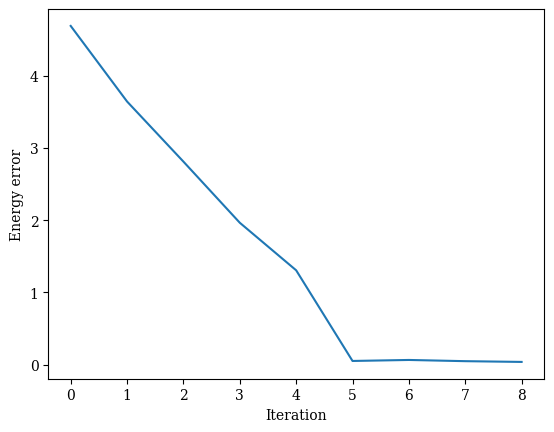

In [61]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

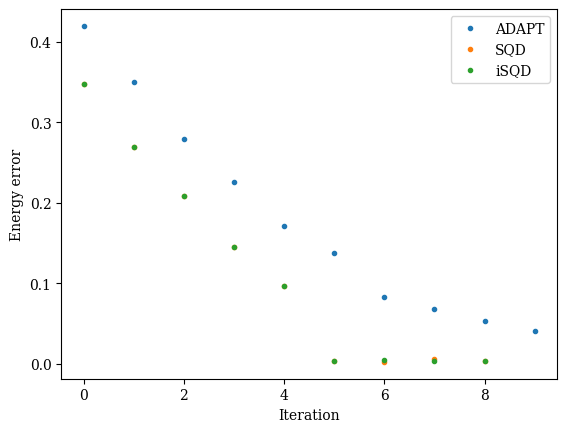

In [62]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="SQD")
ax.plot(stacked_rel_errors, '.', label="iSQD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()

## How many did we keep?

In [63]:
num_kept = []
total_shots = []
for bit_array in bit_arrays:
    bit_matrix = bit_array.to_bool_array()
    original_size = bit_matrix.shape[0]
    bit_matrix = sort_and_remove_duplicates(bit_matrix)
    new_size = bit_matrix.shape[0]
    num_kept.append(new_size)
    total_shots.append(original_size)

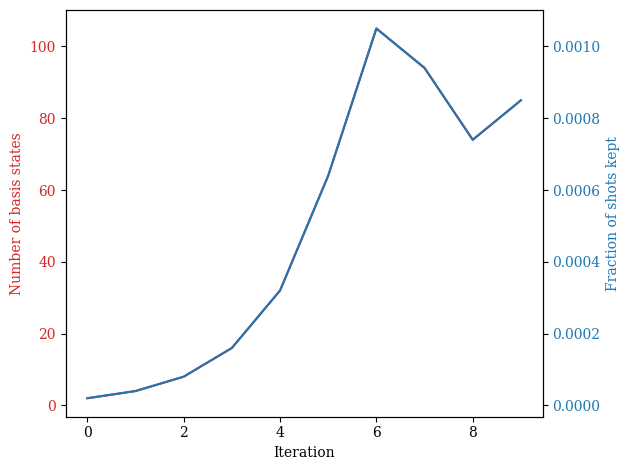

In [64]:
ratio_kept = np.array(num_kept) / np.array(total_shots)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Number of basis states', color=color)
ax1.plot(num_kept, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fraction of shots kept', color=color)  # we already handled the x-label with ax1
ax2.plot(ratio_kept, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

In [65]:
qasm_strs = []
for circuit in circuits:
    # print(circuit.num_qubits)
    # isa_circuit = pass_manager.run(circuit)
    # print(isa_circuit.num_qubits)
    isa_circuit = circuit
    qasm_str = dumps(isa_circuit)
    qasm_strs.append(qasm_str)

In [66]:
f = h5py.File("data/xxz_output.hdf5", "w")
f.create_dataset("qasm_strs", data=qasm_strs)
f.create_dataset("exact_energy", data=exact_energy)
f.create_dataset("adapt_errors", data=np.array(adapt_errors))
f.create_dataset("sqd_errors", data=np.array(errors))
f.create_dataset("isqd_errors", data=np.array(stacked_errors))
f.close()